## Comparação da Melhor Bateria entre timesteps

Neste notebook, comparamos diferentes timesteps para determinar qual configuração resulta na melhor performance da bateria do drone. Abaixo, apresentamos uma visualização do ambiente do armazém, incluindo a posição inicial do drone e os pontos do armazém.

In [2]:
import matplotlib.pyplot as plt

from z3 import *
import numpy


In [3]:
# Definindo os parâmetros que podem ser editados de acordo com a necessidade
num_rows = 4       # Número de "linhas" ou grupos de coordenadas no eixo X
num_columns = 4   # Número de colunas de coordenadas no eixo Y
x_step = 2         # Distância entre as "linhas" no eixo X
x_offset = 3       # Deslocamento (offset) inicial no eixo X
y_offset = 1       # Deslocamento (offset) inicial no eixo Y

# Lista para armazenar todas as coordenadas do armazém
warehouse = []

# Criação das coordenadas do armazém
for i in range(num_rows):
    # 'i' representa cada linha de coordenadas que será criada
    for j in range(num_columns):
        # 'j' representa cada coluna na linha correspondente
        x = x_step * i + x_offset  # Cálculo da coordenada X
        y = j + y_offset           # Cálculo da coordenada Y
        warehouse.append((x, y))   # Adiciona a tupla (x, y) na lista

# Exibe a lista de coordenadas
print("Coordenadas do armazém:", warehouse)

# Definição da posição inicial do drone, pode ser alterada conforme necessidade
drone = (0, 0)
print("Posição inicial do drone:", drone)


Coordenadas do armazém: [(3, 1), (3, 2), (3, 3), (3, 4), (5, 1), (5, 2), (5, 3), (5, 4), (7, 1), (7, 2), (7, 3), (7, 4), (9, 1), (9, 2), (9, 3), (9, 4)]
Posição inicial do drone: (0, 0)


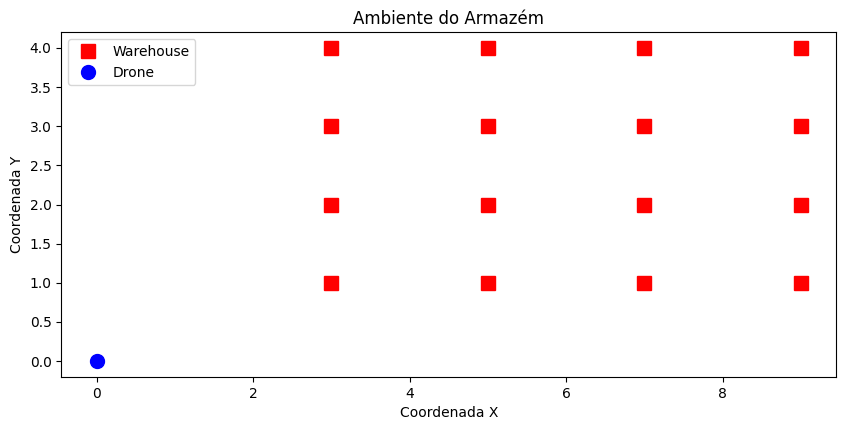

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot dos pontos do armazém
ax.plot(
    [x for x, y in warehouse],
    [y for x, y in warehouse],
    'rs',
    markersize=10,
    label='Warehouse'
)

# Plot da posição do drone
ax.plot(drone[0], drone[1], 'bo', markersize=10, label='Drone')

# Adiciona título e rótulos nos eixos
ax.set_title('Ambiente do Armazém')
ax.set_xlabel('Coordenada X')
ax.set_ylabel('Coordenada Y')

# Define a proporção igual para os eixos
ax.set_aspect('equal')

# Exibe a legenda
ax.legend()

plt.show()

# Melhor bateria com menor timesteps

unsat timesteps: 1
unsat timesteps: 2
unsat timesteps: 3
unsat timesteps: 4
unsat timesteps: 5
unsat timesteps: 6
unsat timesteps: 7
unsat timesteps: 8
unsat timesteps: 9
unsat timesteps: 10
unsat timesteps: 11
unsat timesteps: 12
unsat timesteps: 13
unsat timesteps: 14
unsat timesteps: 15
unsat timesteps: 16
unsat timesteps: 17
unsat timesteps: 18
unsat timesteps: 19
unsat timesteps: 20
unsat timesteps: 21
unsat timesteps: 22
unsat timesteps: 23
unsat timesteps: 24
unsat timesteps: 25
unsat timesteps: 26
unsat timesteps: 27
sat timesteps: 28
Solução viável encontrada com 28 timesteps.

Trajetória com maior bateria final: 43

Trajetória ótima:
Passo 0: Posição (0, 0), Bateria 100
Passo 1: Posição (1, 1), Bateria 97
Passo 2: Posição (2, 2), Bateria 94
Passo 3: Posição (3, 2), Bateria 92
Passo 4: Posição (3, 3), Bateria 90
Passo 5: Posição (3, 4), Bateria 88
Passo 6: Posição (4, 4), Bateria 86
Passo 7: Posição (5, 4), Bateria 84
Passo 8: Posição (5, 3), Bateria 82
Passo 9: Posição (5, 2)

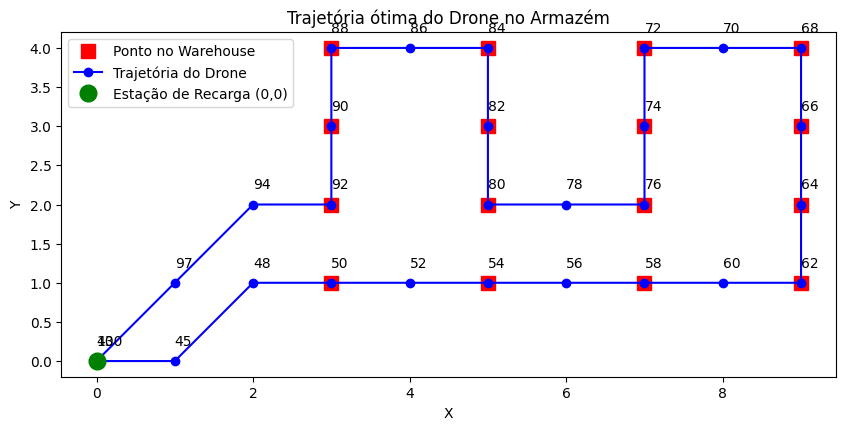

In [9]:
from z3 import *
import matplotlib.pyplot as plt

def find_minimum_timesteps(max_timesteps, bmax, gridx, gridy, warehouse):
    """
    Procura, com um solver simples, o menor número de timesteps em que
    existe uma solução viável que visita todos os pontos do warehouse.
    """
    for timesteps in range(1, max_timesteps + 1):
        s = Solver()

        # Declaração das variáveis para cada timestep
        PGx = [Int(f'pgx_{k}') for k in range(timesteps)]
        PGy = [Int(f'pgy_{k}') for k in range(timesteps)]
        Bat = [Int(f'bat_{k}') for k in range(timesteps)]

        # Restrições de limites para as variáveis
        for b in Bat:
            s.add(And(b >= 1, b <= bmax))
        for x in PGx:
            s.add(And(x >= 0, x <= gridx))
        for y in PGy:
            s.add(And(y >= 0, y <= gridy))

        # Condições iniciais
        s.add(PGx[0] == 0, PGy[0] == 0, Bat[0] == bmax)

        # Restrições de movimento e consumo de bateria
        for k in range(1, timesteps):
            s.add(Or(PGx[k] == PGx[k-1] + 1, PGx[k] == PGx[k-1] - 1, PGx[k] == PGx[k-1]))
            s.add(Or(PGy[k] == PGy[k-1] + 1, PGy[k] == PGy[k-1] - 1, PGy[k] == PGy[k-1]))
            
            # Impede que o drone permaneça na mesma posição
            s.add(Not(And(PGx[k] == PGx[k-1], PGy[k] == PGy[k-1])))
            
            s.add(If(
                Or(
                    And(PGx[k] == PGx[k-1] + 1, PGy[k] == PGy[k-1] + 1),
                    And(PGx[k] == PGx[k-1] - 1, PGy[k] == PGy[k-1] - 1),
                    And(PGx[k] == PGx[k-1] + 1, PGy[k] == PGy[k-1] - 1),
                    And(PGx[k] == PGx[k-1] - 1, PGy[k] == PGy[k-1] + 1)
                ),
                Bat[k] == Bat[k-1] - 3,
                If(
                    Or(
                        And(PGx[k] == PGx[k-1] + 1, PGy[k] == PGy[k-1]),
                        And(PGx[k] == PGx[k-1] - 1, PGy[k] == PGy[k-1]),
                        And(PGx[k] == PGx[k-1], PGy[k] == PGy[k-1] - 1),
                        And(PGx[k] == PGx[k-1], PGy[k] == PGy[k-1] + 1)
                    ),
                    Bat[k] == Bat[k-1] - 2,
                    Bat[k] == Bat[k-1]
                )
            ))

        # Cada ponto no warehouse deve ser visitado em algum timestep
        for (x, y) in warehouse:
            s.add(Or([And(PGx[k] == x, PGy[k] == y) for k in range(timesteps)]))

        # Adicionando restrição para que, no último timestep, o drone retorne ao ponto inicial (0,0)
        s.add(PGx[timesteps - 1] == 0)
        s.add(PGy[timesteps - 1] == 0)
        
        if s.check() == sat:
            print(s.check(), "timesteps:", timesteps)
            return timesteps  # Retorna o menor número de timesteps viável
        else:
            print(s.check(), "timesteps:", timesteps)
    return None

def optimize_battery(timesteps, bmax, gridx, gridy, warehouse):
    """
    Com um número fixo de timesteps (mínimo encontrado), configura as
    restrições e usa o Optimize para maximizar a bateria no último passo.
    """
    opt = Optimize()

    PGx = [Int(f'pgx_{k}') for k in range(timesteps)]
    PGy = [Int(f'pgy_{k}') for k in range(timesteps)]
    Bat = [Int(f'bat_{k}') for k in range(timesteps)]

    for b in Bat:
        opt.add(And(b >= 1, b <= bmax))
    for x in PGx:
        opt.add(And(x >= 0, x <= gridx))
    for y in PGy:
        opt.add(And(y >= 0, y <= gridy))

    opt.add(PGx[0] == 0, PGy[0] == 0, Bat[0] == bmax)

    # Restrições de movimento e consumo de bateria
    for k in range(1, timesteps):
        # Restrições de movimento permitidas para cada coordenada
        opt.add(Or(PGx[k] == PGx[k-1] + 1, PGx[k] == PGx[k-1] - 1, PGx[k] == PGx[k-1]))
        opt.add(Or(PGy[k] == PGy[k-1] + 1, PGy[k] == PGy[k-1] - 1, PGy[k] == PGy[k-1]))
        
        # Impede que o drone permaneça parado (ambas as coordenadas iguais ao timestep anterior)
        opt.add(Not(And(PGx[k] == PGx[k-1], PGy[k] == PGy[k-1])))

        # Restrições de consumo de bateria com base no tipo de movimento
        opt.add(If(
            Or(
                And(PGx[k] == PGx[k-1] + 1, PGy[k] == PGy[k-1] + 1),
                And(PGx[k] == PGx[k-1] - 1, PGy[k] == PGy[k-1] - 1),
                And(PGx[k] == PGx[k-1] + 1, PGy[k] == PGy[k-1] - 1),
                And(PGx[k] == PGx[k-1] - 1, PGy[k] == PGy[k-1] + 1)
            ),
            Bat[k] == Bat[k-1] - 3,
            If(
                Or(
                    And(PGx[k] == PGx[k-1] + 1, PGy[k] == PGy[k-1]),
                    And(PGx[k] == PGx[k-1] - 1, PGy[k] == PGy[k-1]),
                    And(PGx[k] == PGx[k-1], PGy[k] == PGy[k-1] - 1),
                    And(PGx[k] == PGx[k-1], PGy[k] == PGy[k-1] + 1)
                ),
                Bat[k] == Bat[k-1] - 2,
                Bat[k] == Bat[k-1]
            )
        ))

    for (x, y) in warehouse:
        opt.add(Or([And(PGx[k] == x, PGy[k] == y) for k in range(timesteps)]))

    # Adicionando restrição para que, no último timestep, o drone retorne ao ponto inicial (0,0)
    opt.add(PGx[timesteps - 1] == 0)
    opt.add(PGy[timesteps - 1] == 0)
    
    # Objetivo: maximizar a bateria no último timestep
    opt.maximize(Bat[timesteps - 1])
    
    if opt.check() == sat:
        m = opt.model()
        melhor_bateria = m.evaluate(Bat[timesteps - 1]).as_long()
        return m, PGx, PGy, Bat, melhor_bateria
    return None, None, None, None, None

# Parâmetros do problema
max_timesteps = 100  # Limite superior para a busca de timesteps
bmax = 100
gridx = 9
gridy = 10

# Fase 1: Encontra o menor número de timesteps com uma solução viável
min_timesteps = find_minimum_timesteps(max_timesteps, bmax, gridx, gridy, warehouse)
if min_timesteps is None:
    print("Nenhuma solução encontrada até", max_timesteps, "timesteps.")
else:
    print(f"Solução viável encontrada com {min_timesteps} timesteps.")
    
    # Fase 2: Com o número mínimo de timesteps, otimiza para maximizar a bateria final
    modelo, PGx, PGy, Bat, melhor_bateria = optimize_battery(min_timesteps, bmax, gridx, gridy, warehouse)
    
    if modelo:
        print("\nTrajetória com maior bateria final:", melhor_bateria)
        pgx_values = [modelo.evaluate(PGx[k]).as_long() for k in range(min_timesteps)]
        pgy_values = [modelo.evaluate(PGy[k]).as_long() for k in range(min_timesteps)]
        bat_values = [modelo.evaluate(Bat[k]).as_long() for k in range(min_timesteps)]
        
        print("\nTrajetória ótima:")
        for t in range(min_timesteps):
            print(f"Passo {t}: Posição ({pgx_values[t]}, {pgy_values[t]}), Bateria {bat_values[t]}")
        
        # Visualização da trajetória
        fig, ax = plt.subplots(figsize=(10, 6))
        # Plotando os pontos do warehouse
        for i, (x, y) in enumerate(warehouse):
            if i == 0:
                ax.plot(x, y, 'rs', markersize=10, label="Ponto no Warehouse")
            else:
                ax.plot(x, y, 'rs', markersize=10)
        # Plotando a trajetória do drone
        ax.plot(pgx_values, pgy_values, 'b-o', label="Trajetória do Drone")
        ax.plot(0, 0, 'go', markersize=12, label="Estação de Recarga (0,0)")
        for t in range(min_timesteps):
            ax.text(pgx_values[t], pgy_values[t] + 0.2, f'{bat_values[t]}', fontsize=10)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("Trajetória ótima do Drone no Armazém")
        plt.legend()
        ax.set_aspect('equal')
        plt.show()
    else:
        print("Falha na otimização da bateria.")


# Melhor bateria timesteps definido

unsat timesteps: 1
unsat timesteps: 2
unsat timesteps: 3
unsat timesteps: 4
unsat timesteps: 5
unsat timesteps: 6
unsat timesteps: 7
unsat timesteps: 8
unsat timesteps: 9
unsat timesteps: 10
unsat timesteps: 11
unsat timesteps: 12
unsat timesteps: 13
unsat timesteps: 14
unsat timesteps: 15
unsat timesteps: 16
unsat timesteps: 17
unsat timesteps: 18
unsat timesteps: 19
unsat timesteps: 20
unsat timesteps: 21
unsat timesteps: 22
unsat timesteps: 23
unsat timesteps: 24
unsat timesteps: 25
unsat timesteps: 26
unsat timesteps: 27
sat timesteps: 28
sat timesteps: 29
Solução viável encontrada com 29 timesteps.

Trajetória com maior bateria final: 42

Trajetória ótima:
Passo 0: Posição (0, 0), Bateria 100
Passo 1: Posição (1, 1), Bateria 97
Passo 2: Posição (2, 1), Bateria 95
Passo 3: Posição (3, 1), Bateria 93
Passo 4: Posição (4, 1), Bateria 91
Passo 5: Posição (5, 1), Bateria 89
Passo 6: Posição (5, 2), Bateria 87
Passo 7: Posição (5, 3), Bateria 85
Passo 8: Posição (6, 3), Bateria 83
Passo

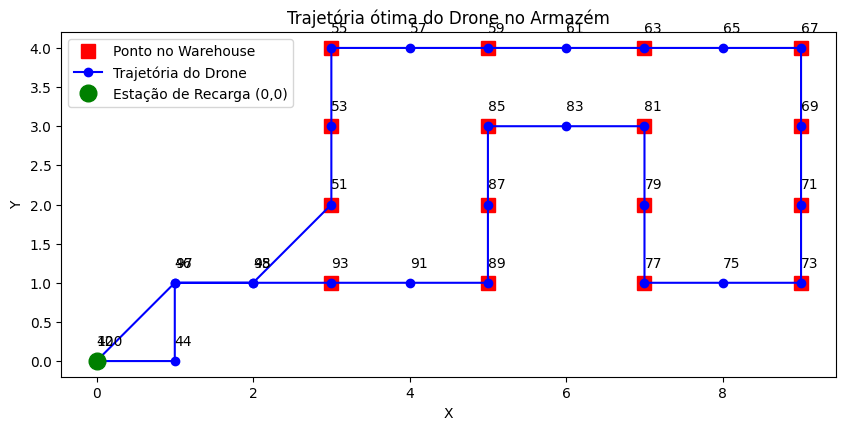

In [10]:
from z3 import *
import matplotlib.pyplot as plt

def find_minimum_timesteps(max_timesteps, bmax, gridx, gridy, warehouse):
    """
    Procura, com um solver simples, o menor número de timesteps em que
    existe uma solução viável que visita todos os pontos do warehouse.
    """
    for timesteps in range(1, max_timesteps + 1):
        s = Solver()

        # Declaração das variáveis para cada timestep
        PGx = [Int(f'pgx_{k}') for k in range(timesteps)]
        PGy = [Int(f'pgy_{k}') for k in range(timesteps)]
        Bat = [Int(f'bat_{k}') for k in range(timesteps)]

        # Restrições de limites para as variáveis
        for b in Bat:
            s.add(And(b >= 1, b <= bmax))
        for x in PGx:
            s.add(And(x >= 0, x <= gridx))
        for y in PGy:
            s.add(And(y >= 0, y <= gridy))

        # Condições iniciais
        s.add(PGx[0] == 0, PGy[0] == 0, Bat[0] == bmax)

        # Restrições de movimento e consumo de bateria
        for k in range(1, timesteps):
            s.add(Or(PGx[k] == PGx[k-1] + 1, PGx[k] == PGx[k-1] - 1, PGx[k] == PGx[k-1]))
            s.add(Or(PGy[k] == PGy[k-1] + 1, PGy[k] == PGy[k-1] - 1, PGy[k] == PGy[k-1]))
            
            # Impede que o drone permaneça na mesma posição
            s.add(Not(And(PGx[k] == PGx[k-1], PGy[k] == PGy[k-1])))
            
            s.add(If(
                Or(
                    And(PGx[k] == PGx[k-1] + 1, PGy[k] == PGy[k-1] + 1),
                    And(PGx[k] == PGx[k-1] - 1, PGy[k] == PGy[k-1] - 1),
                    And(PGx[k] == PGx[k-1] + 1, PGy[k] == PGy[k-1] - 1),
                    And(PGx[k] == PGx[k-1] - 1, PGy[k] == PGy[k-1] + 1)
                ),
                Bat[k] == Bat[k-1] - 3,
                If(
                    Or(
                        And(PGx[k] == PGx[k-1] + 1, PGy[k] == PGy[k-1]),
                        And(PGx[k] == PGx[k-1] - 1, PGy[k] == PGy[k-1]),
                        And(PGx[k] == PGx[k-1], PGy[k] == PGy[k-1] - 1),
                        And(PGx[k] == PGx[k-1], PGy[k] == PGy[k-1] + 1)
                    ),
                    Bat[k] == Bat[k-1] - 2,
                    Bat[k] == Bat[k-1]
                )
            ))

        # Cada ponto no warehouse deve ser visitado em algum timestep
        for (x, y) in warehouse:
            s.add(Or([And(PGx[k] == x, PGy[k] == y) for k in range(timesteps)]))

        # Adicionando restrição para que, no último timestep, o drone retorne ao ponto inicial (0,0)
        s.add(PGx[timesteps - 1] == 0)
        s.add(PGy[timesteps - 1] == 0)
        
        if s.check() == sat:
            print(s.check(), "timesteps:", timesteps)
            result = timesteps
        else:
            print(s.check(), "timesteps:", timesteps)
            result = None
    return result

def optimize_battery(timesteps, bmax, gridx, gridy, warehouse):
    """
    Com um número fixo de timesteps (mínimo encontrado), configura as
    restrições e usa o Optimize para maximizar a bateria no último passo.
    """
    opt = Optimize()

    PGx = [Int(f'pgx_{k}') for k in range(timesteps)]
    PGy = [Int(f'pgy_{k}') for k in range(timesteps)]
    Bat = [Int(f'bat_{k}') for k in range(timesteps)]

    for b in Bat:
        opt.add(And(b >= 1, b <= bmax))
    for x in PGx:
        opt.add(And(x >= 0, x <= gridx))
    for y in PGy:
        opt.add(And(y >= 0, y <= gridy))

    opt.add(PGx[0] == 0, PGy[0] == 0, Bat[0] == bmax)

    for k in range(1, timesteps):
        # Restrições de movimento permitidas para cada coordenada
        opt.add(Or(PGx[k] == PGx[k-1] + 1, PGx[k] == PGx[k-1] - 1, PGx[k] == PGx[k-1]))
        opt.add(Or(PGy[k] == PGy[k-1] + 1, PGy[k] == PGy[k-1] - 1, PGy[k] == PGy[k-1]))
        
        # Impede que o drone permaneça parado (ambas as coordenadas iguais ao timestep anterior)
        opt.add(Not(And(PGx[k] == PGx[k-1], PGy[k] == PGy[k-1])))

        # Restrições de consumo de bateria com base no tipo de movimento
        opt.add(If(
            Or(
                And(PGx[k] == PGx[k-1] + 1, PGy[k] == PGy[k-1] + 1),
                And(PGx[k] == PGx[k-1] - 1, PGy[k] == PGy[k-1] - 1),
                And(PGx[k] == PGx[k-1] + 1, PGy[k] == PGy[k-1] - 1),
                And(PGx[k] == PGx[k-1] - 1, PGy[k] == PGy[k-1] + 1)
            ),
            Bat[k] == Bat[k-1] - 3,
            If(
                Or(
                    And(PGx[k] == PGx[k-1] + 1, PGy[k] == PGy[k-1]),
                    And(PGx[k] == PGx[k-1] - 1, PGy[k] == PGy[k-1]),
                    And(PGx[k] == PGx[k-1], PGy[k] == PGy[k-1] - 1),
                    And(PGx[k] == PGx[k-1], PGy[k] == PGy[k-1] + 1)
                ),
                Bat[k] == Bat[k-1] - 2,
                Bat[k] == Bat[k-1]
            )
        ))


    for (x, y) in warehouse:
        opt.add(Or([And(PGx[k] == x, PGy[k] == y) for k in range(timesteps)]))

    # Adicionando restrição para que, no último timestep, o drone retorne ao ponto inicial (0,0)
    opt.add(PGx[timesteps - 1] == 0)
    opt.add(PGy[timesteps - 1] == 0)
    
    # Objetivo: maximizar a bateria no último timestep
    opt.maximize(Bat[timesteps - 1])
    
    if opt.check() == sat:
        m = opt.model()
        melhor_bateria = m.evaluate(Bat[timesteps - 1]).as_long()
        return m, PGx, PGy, Bat, melhor_bateria
    return None, None, None, None, None

# Parâmetros do problema
max_timesteps = 29  # Limite superior para a busca de timesteps
bmax = 100
gridx = 12
gridy = 10

# Fase 1: Encontra o menor número de timesteps com uma solução viável
min_timesteps = find_minimum_timesteps(max_timesteps, bmax, gridx, gridy, warehouse)
if min_timesteps is None:
    print("Nenhuma solução encontrada até", max_timesteps, "timesteps.")
else:
    print(f"Solução viável encontrada com {min_timesteps} timesteps.")
    
    # Fase 2: Com o número mínimo de timesteps, otimiza para maximizar a bateria final
    modelo, PGx, PGy, Bat, melhor_bateria = optimize_battery(min_timesteps, bmax, gridx, gridy, warehouse)
    
    if modelo:
        print("\nTrajetória com maior bateria final:", melhor_bateria)
        pgx_values = [modelo.evaluate(PGx[k]).as_long() for k in range(min_timesteps)]
        pgy_values = [modelo.evaluate(PGy[k]).as_long() for k in range(min_timesteps)]
        bat_values = [modelo.evaluate(Bat[k]).as_long() for k in range(min_timesteps)]
        
        print("\nTrajetória ótima:")
        for t in range(min_timesteps):
            print(f"Passo {t}: Posição ({pgx_values[t]}, {pgy_values[t]}), Bateria {bat_values[t]}")
        
        # Visualização da trajetória
        fig, ax = plt.subplots(figsize=(10, 6))
        # Plotando os pontos do warehouse
        for i, (x, y) in enumerate(warehouse):
            if i == 0:
                ax.plot(x, y, 'rs', markersize=10, label="Ponto no Warehouse")
            else:
                ax.plot(x, y, 'rs', markersize=10)
        # Plotando a trajetória do drone
        ax.plot(pgx_values, pgy_values, 'b-o', label="Trajetória do Drone")
        ax.plot(0, 0, 'go', markersize=12, label="Estação de Recarga (0,0)")
        for t in range(min_timesteps):
            ax.text(pgx_values[t], pgy_values[t] + 0.2, f'{bat_values[t]}', fontsize=10)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("Trajetória ótima do Drone no Armazém")
        plt.legend()
        ax.set_aspect('equal')
        plt.show()
    else:
        print("Falha na otimização da bateria.")
